In [2]:
import os
from utils.metrics import ap_per_class
from post_util import process_batch
from PIL import Image
import torchvision.transforms as T
from load_data import boxes2labs
import torch.nn.functional as F
%matplotlib inline

import patch_config
from models.experimental import attempt_load
import numpy as np
import torch
from utils.general import non_max_suppression, xywh2xyxy
import torchvision
from load_data import InriaDataset, PatchApplier, PatchTransformer, preds2boxes, TotalVariation
import matplotlib.pyplot as plt
from post_util import plot_boxes, get_region_boxes

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
cfg = patch_config.patch_configs['yolov4tiny']()
model = cfg.model

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs


In [117]:
data_loader = torch.utils.data.DataLoader(
    InriaDataset(cfg.val_img_dir, None, None, cfg.img_size),
    # InriaDataset(cfg.img_dir, cfg.lab_dir, 20, cfg.img_size),
    batch_size=1,
    shuffle=False,
    num_workers=0)
train_loader = torch.utils.data.DataLoader(
    InriaDataset(cfg.img_dir, None, None, cfg.img_size),
    batch_size=1,
    shuffle=False,
    num_workers=0)
patch_img = "patches/Hu/v4tiny.png"
adv_patch = Image.open(patch_img).convert('RGB')
adv_patch = T.Compose([T.ToTensor()])(adv_patch).cuda()
adv_patch_init = adv_patch.detach().clone()
patch_applier = PatchApplier().cuda()
patch_transformer = PatchTransformer().cuda()

In [118]:
it = iter(train_loader)

In [129]:
img_batch, _ = next(it)
img_batch = img_batch.cuda()

In [32]:
patch = T.ToTensor()(Image.open('patches/PNAP/init.png').convert('RGB')).cuda()

In [33]:
noise = torch.randn_like(patch) * 0.4
patch = patch + noise
patch = torch.clamp(patch, 0, 1)
T.ToPILImage()(patch).save('patch.png')

In [13]:
preds_orig = model(F.interpolate(img_batch, cfg.imgsz))
preds_orig = preds2boxes(cfg, preds_orig)
adv_batch = patch_transformer(patch, boxes2labs(preds_orig), 416)

NameError: name 'img_batch' is not defined

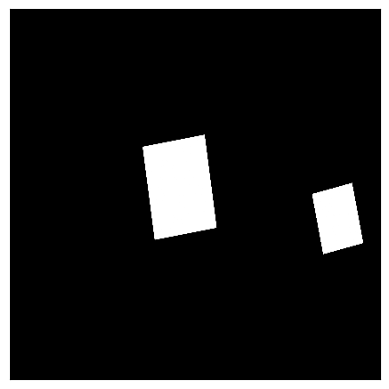

In [132]:
%matplotlib inline
b = torch.zeros((1, 3, 416, 416), dtype=torch.float).cuda()
advs = torch.unbind(adv_batch[1], 1)
for adv in advs:
    b = torch.where((adv == 0), b, adv)
plt.imshow(b[0].cpu().permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

In [133]:
pbatch = patch_applier(img_batch, adv_batch[0])

In [134]:
T.ToPILImage()(b[0]).save('mask.png')
T.ToPILImage()(img_batch[0]).save('aa.png')
T.ToPILImage()(pbatch[0]).save('b.png')

In [9]:
gt_path = os.path.join(os.getcwd(), 'temps', 'gt', f'{cfg.patch_name}')
dr_path = os.path.join(os.getcwd(), 'temps', 'dr', f'{cfg.patch_name}')
if not os.path.exists(gt_path):
    os.makedirs(gt_path)
if not os.path.exists(dr_path):
    os.makedirs(dr_path)

for i_batch, (img_batch, img_paths) in enumerate(data_loader):
    img_batch = img_batch.cuda()
    with torch.no_grad():
        preds_orig = model(F.interpolate(img_batch, cfg.imgsz))
    preds_orig = preds2boxes(cfg, preds_orig)
    adv_batch_t = patch_transformer(adv_patch, boxes2labs(preds_orig), cfg.img_size,
                                    do_blur=False,
                                    do_rotate=False,
                                    rand_loc=False,
                                    do_aug=False,
                                    by_rectangle=True)
    p_img_batch = patch_applier(img_batch, adv_batch_t)
    with torch.no_grad():
        preds_patched = model(F.interpolate(p_img_batch, cfg.imgsz))
    preds_patched = preds2boxes(cfg, preds_patched)
    for gt_pred, dr_pred, img_path in zip(preds_orig, preds_patched, img_paths):
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        gt_box = gt_pred[:, :4]
        dr_box = dr_pred[:, :4]
        dr_confs = dr_pred[:, 4]
        gt_box = gt_box.cpu().numpy()
        dr_box = dr_box.cpu().numpy()
        gt_box = xywh2xyxy(gt_box)
        dr_box = xywh2xyxy(dr_box)
        gt_box = np.round(gt_box * cfg.img_size)
        dr_box = np.round(dr_box * cfg.img_size)
        with open(os.path.join(gt_path, f'{img_name}.txt'), 'w') as f:
            for box in gt_box:
                coords = ' '.join(map(str, box))
                f.write(f'target {coords}\n')
            f.close()
        with open(os.path.join(dr_path, f'{img_name}.txt'), 'w') as f:
            for box, dr_conf in zip(dr_box, dr_confs):
                coords = ' '.join(map(str, box))
                f.write(f'target {dr_conf} {coords}' + '\n')
            f.close()

KeyboardInterrupt: 

In [8]:
from tools import map_cal

map50 = map_cal.count(path_ground_truth=gt_path,
                      path_detection_results=dr_path)
print(map50)

GT_PATH :
/home/chanvo/projects/multi-task-attck/AP-PA/temps/gt/yolov4tiny
22.09% = target AP 
mAP = 22.09%
0.22093886539344618
